# This imports CSV data from CBOE and then processes it 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import csv
from datetime import datetime
from datetime import timedelta

In [2]:
def getcsvD():
    titles = ['underlying_symbol','quote_datetime','root','expiration','strike','option_type','open','high','low','close','trade_volume','bid_size','bid','ask_size','ask','underlying_bid','underlying_ask','implied_underlying_price','active_underlying_price','implied_volatility',	'delta','gamma','theta','vega','rho','hash_value']
    i  = 0 
    csvD = {} #csvDictionary give it a column name and it returns its index 
    for i in range(0, len(titles)): 
        csvD[titles[i]] = i 
    return csvD 

In [3]:
def genPositionfromRow(row,csvD):
    newPosition = Position()
    newPosition.startTime = row[csvD["quote_datetime"]]
    newPosition.hashValue = row[csvD["hash_value"]]
    return newPosition 

In [4]:
#Does not account for market holidays 
def makeFileList(startDate,endDate,directory):
    cDate = startDate 
    fileList = []
    startString = "UnderlyingOptionsIntervalsCalcs_60sec_" 
    endString = ".csv"
    oneDay = timedelta(days=1) #defines a 1day time delta so you can iterate forward one day 
    while(cDate<=endDate): 
        if not ((cDate.weekday()==5) or (cDate.weekday()==6)): #if cDate is saturday or sunday don't do the following thing ADD hol later
            fileName = directory+startString+str(cDate.date())+endString
            fileList.append(fileName)
        cDate = cDate + oneDay
    return fileList

In [5]:
class TSlist:
    def __init__(self):
         self.t = []
         self.v = []
    def getValue(self,row,col):
        if(col==0):
            return self.t[row]
        if(col==1):
            return self.v[row]
    def gett(self):
        return self.t
    def getv(self):
        return self.v
    
    def setCell(self,row,col,newValue):
        if(col==0):
            self.t[row] = self.v
        if(col==1):
            self.v[row] = newValue 
    def appendTS(self,tValue,vValue):
        self.t.append(tValue)
        self.v.append(vValue)
    def makeNParray(self):
        return np.array([self.t,self.v]).transpose() 
        
class Indicator: 
    def __init__(self):
        self.stockData = TSlist()
        self.endOfFile = False 
    def getMA(self,minBack):
        movAvg = np.ndarray([len(self.stockData.getv()),2])
        for i in range(0,len(self.stockData.getv())):
            movAvg[i][0] = self.stockData.getValue(i,0)
            if i<minBack:
                movAvg[i][1] = 0
            else:
                total = 0 
                for j in range(0,minBack):
                    total = total+self.stockData.getValue(i-j,1)
                movAvg[i][1] = (total+0.0)/(minBack+0.0)
        return movAvg
    
    def updateStockData(self,newQuote):
        self.i = self.i+1 
        self.stockData.appendTS(newQuote[0],newQuote[1])
               
class Position: 
    def __init__(self):
        self.startTime = None #datetime.strptime("1000-1-1","%Y-%m-%d")
        self.endTime = None #datetime.strptime("1000-1-1","%Y-%m-%d")
        self.hashValue = "" 
        self.timeSeriesDF = pd.DataFrame() 
        self.quanity = 0
    def calcProfit(self):
        if not (pd.DataFrame(self.timeSeriesDF["quote_datetime"]==pd.Timestamp(self.endTime)).sum()[0] and pd.DataFrame(self.timeSeriesDF["quote_datetime"]==pd.Timestamp(self.startTime)).sum()[0]):
            return 0 #hopefully this will fix things 
        return self.quanity*(self.timeSeriesDF[self.timeSeriesDF["quote_datetime"] == pd.Timestamp(self.endTime)]["bid"].iloc[0] -self.timeSeriesDF[self.timeSeriesDF["quote_datetime"] == pd.Timestamp(self.startTime)]["bid"].iloc[0])
    def setExit(self,exitTime):
        if(pd.DataFrame(self.timeSeriesDF["quote_datetime"]==pd.Timestamp(exitTime)).sum()[0]):
            self.endTime = exitTime 
    #def setStartTime(startTime):
    #    self.startTime = startTime
    #def setEndTime(endTime):
    #    self.endTime = endTime 
    #def setTimeSeriesDF(timeSeriesDF):
    #    self.timeSeriesDF = timeSeriesDF 
class CalPosition:
    def __init__(self,posLong,posShort):
        self.posLong = posLong
        self.posShort = posShort
        self.dateTimeD = {}
        #generates np array very inefficently
        tmpDictionary = self.posShort.timeSeriesDF.to_dict('list')  #might be a more efficent way to work with this.... 
        dateTimeList = tmpDictionary["quote_datetime"]
        
        self.profitArray = np.zeros([len(dateTimeList),2])
        i =0 
        for dt in dateTimeList:
            posLong.endTime = dt 
            posShort.endTime = dt 
            self.profitArray[i,0] = i #str(dt) 
            self.dateTimeD[i] = dt
            self.profitArray[i,0] = posLong.calcProfit()+posShort.calcProfit()
            i = i + 1 
    def setExit(self,exit):
        self.posLong.setExit(exit)
        self.posShort.setExit(exit)
    def calcProfit(self):
        return self.posLong.calcProfit() + self.posShort.calcProfit()
    

In [6]:
def dataProcessor(csvFileName,optionD,positions,indicator,csvD): #for clarity of the code this is not generalized and will only work with CBOD database 
    #this is an array of titles that corresponds to the order in the csv files 
    #for example tiles[3] returns a string root 
    #this makes the code much more readable 
    
    newOptionD = optionD.copy() 

    titles = ['underlying_symbol','quote_datetime','root','expiration','strike','option_type','open','high','low','close','trade_volume','bid_size','bid','ask_size','ask','underlying_bid','underlying_ask','implied_underlying_price','active_underlying_price','implied_volatility',	'delta','gamma','theta','vega','rho','hash_value']

    j = 0 
    #this is needed for the stragegy to fuction properly 
    minList = [] #minute list 
    with open(csvFileName, 'rb') as f: #opens the 
        reader = csv.reader(f)
        for row in reader:
            #this processes the string and makes sure each part of the list has the correct datatype 
            if (j ==0):  #skips the first header line 
                j = 1 
                continue 
            #sets the hashValue 
            hashValue =  row[csvD['root']]  + '|' +row[csvD['expiration']]+ '|'+row[csvD['strike']]+'|'+row[csvD['option_type']]
            #changes the datatype of the elements in the row list 
            row[csvD['quote_datetime']] = datetime.strptime(row[csvD['quote_datetime']] ,'%Y-%m-%d %H:%M:%S') #these should be changed to datetime64 
            row[csvD['expiration']] = datetime.strptime(row[csvD['expiration']] +' 16:15:00','%Y-%m-%d %H:%M:%S') #assumes 4:00 est close
            for i in range(csvD['strike'],csvD['rho']+1): #turns all of the float rows into floats 
                if i != csvD['option_type']: #avoids the option time column when trying to float convert 
                    #for testing purposes 
                    #oldRow = row[i]
                    row[i] = float(row[i])
                    #if(i == 12 and row[i]>0): 
                        #print oldRow +" <-old new->" + str(row[i]) 
            row.append(hashValue) #adds the hashValue to the row list 
            
            #this part does the stragety stuff 
            result = strategy(row,minList,csvD,indicator,True)
            if(result is not None):
                positions.append(result)
            #this part adds the  option information to optionD 
            if not hashValue in optionD: #if the hashValue isn't in option D ...
                dic = {}  #make a new dictionary 
                for title in titles:  #go through the titles array 
                    dic[title] = [row[csvD[title]]] #make a dictionary where the key is the title and the value is a list 
                                                    #where the first enitry is the value in the row under that tile 
                optionD[hashValue] = dic #store the reference to the new dictionary in the optionD dictionary 
            else:
                dic = optionD[hashValue] #dictionary already exists, so get its reference 
                for title in titles: 
                    dic[title].append(row[csvD[title]]) #append the rows to the list 
        
        #During the last line this is called  
        result = strategy(row,minList,csvD,indicator,False)
        if(result is not None):
            positions.append(result)
    #this line only stores the useful positions in optionD speading up code 
    for p in positions: 
        newOptionD[p.hashValue]=optionD[p.hashValue]
    optionD = newOptionD 
    return optionD 
    

In [7]:
def strategy(row,minList,csvD,indicator,middleLine):
    #if ((len(minList)==0 or minList[-1][csvD["quote_datetime"]]==row[csvD["quote_datetime"]]) and middleLine):
    # print "this was called " + str(middleLine) +" length of min list " + str(len(minList))
    #minList.append(row)
#        return None 
#    else: 
        #return decision1(minList,csvD,indicator)
    return decisionCalander(row,csvD)
        #you are at the end of a min 
        

In [8]:
#not currently in use
def decision1(row,csvD,indicator):
    bestPosition = row 
    #print type(bestPosition[csvD["quote_datetime"]])
    indicator.updateStockData([bestPosition[csvD["quote_datetime"]],bestPosition[csvD["strike"]]])
    #for positions in minList: 
        #if(positions[csvD["bid"]]>bestPosition[csvD["bid"]]):
            #bestPosition = positions
    minList = [] #clears minList f
    return genPositionfromRow(bestPosition,csvD)

   #if(bestPosition[csvD["bid"]]>0):
    #    return genPositionfromRow(bestPosition,csvD)
    #else:
    #    return None 

In [9]:
def decisionCalander(row,csvD):
    decision = None 
    decision = decisionSell(row,csvD)
    if (decision == None): 
        decision = decisionBuy(row,csvD)
    return decision 

In [10]:
def decisionSell(row,csvD): #the minlist is some left over functionality that should be removed later
    deltaRange = 1.0/100.0 
    idealDelta = -50.0/100.0
    timeFudgeRange = timedelta(minutes=5) #change for testing purposes 
    timeOfClose = row[csvD['expiration']].time()
    dateTime = row[csvD["quote_datetime"]]
    timeOfClose = row[csvD["expiration"]]
    fiveWeeks = timedelta(weeks=5)
                           
    #tmpInterval = datetime.strptime(str(dateTime.time()),"%H:%M:%S") - datetime.strptime(str(timeOfClose.time()),"%H:%M:%S")
    #if((tmpInterval)<tmpDelta): #it is the time of the close (not needed right now)

    
    if(row[csvD["expiration"]]-fiveWeeks-row[csvD["quote_datetime"]]<timeFudgeRange): #if quote_datetime around close and expiration 3 weeks out
        if(dateTime.weekday()==4): #is Friday
            if(row[csvD["option_type"]]== "P"): #if option is a put
                if(row[csvD["bid"]]>0): #makes sure bid isn't zero
                    #print row[csvD["delta"]]
                    #print "differience = " + str(row[csvD["delta"]]-idealDelta)
                    if(abs(row[csvD["delta"]]-idealDelta)<deltaRange): #the delta is within 50+/- 100 basically broken for testing
                        newPos = genPositionfromRow(row,csvD) 
                        newPos.quanity = -100 #sells 100 
                        return newPos


    return None 

In [11]:
def decisionBuy(row,csvD):
    timeFudgeRange = timedelta(minutes=5) #change for testing purposes 
    timeOfClose = row[csvD['expiration']].time()
    dateTime = row[csvD["quote_datetime"]]
    timeOfClose = row[csvD["expiration"]]
    threeWeeks = timedelta(weeks=3)
    if(row[csvD["expiration"]]-threeWeeks-row[csvD["quote_datetime"]]<timeFudgeRange):
        if(dateTime.weekday()==4): #is Friday
            if(row[csvD["option_type"]]== "P"): #if option is a put 
                if(row[csvD["bid"]]>0): #makes sure bid isn't zero
                        newPos = genPositionfromRow(row,csvD) 
                        newPos.quanity = 100 #buy 100 
                        return newPos
    return None 

In [12]:
def getCalPositions(positions): #this is inefficent af 
    shorts = []
    longs = []
    calPositions = []
    for p in positions:
        if p.quanity > 0 : 
            longs.append(p)
        else:
            shorts.append(p)
    
    for l in longs: 
        for s in shorts:
            if(abs(l.startTime-s.startTime)<timedelta(hours=10)): #should garantee a match for long pos
                newCal = CalPosition(l,s)
                calPositions.append(newCal)
                shorts.remove(s)
                break; 
           
    
   
    return calPositions 
#getCalPositions(positions)

#### This is the main function for this program. The following block of code takes a while to run

In [13]:
#this is the "main" method for extracting and processing the data 
#example csvFileName = 'C:/data/UnderlyingOptionsIntervalsCalcs_60sec_2009-03-02.csv'

csvD = getcsvD()
startDate = datetime.strptime("2009-03-20","%Y-%m-%d") #inclusive 
endDate = datetime.strptime("2009-03-26","%Y-%m-%d") #inclusive 
directory = "C:/data/"
fileList = makeFileList(startDate,endDate,directory)
positions = []
optionD = {} #this is dictionary of all of the different options. Give a hash function, get an option time series 
indicator = Indicator()
#overrides filelist to speedup code for testing purposes 
fileList = ["C:/data/newTest.csv"]
for csvFileNames in fileList: 
    optionD = dataProcessor(csvFileNames,optionD,positions,indicator,csvD)

In [14]:
#this creates optionPD from optionD 
optionPD = {} #creates a new dictionary of all of the options as a Pandas Dataframe 
nonZeroList = []
for key in optionD: 
    tmp = pd.DataFrame(optionD[key]) #turns the dictionaries into a pandas dataframe
    optionPD[key] = tmp 
    nonZeroList.append(key)


In [15]:
print len(positions)

218


In [16]:
#this code iterates through all of the positions in the list positions and then adds the pandas dataframe them 
#temporary sets exit to final position in dataframe 
for position in positions: 
    position.timeSeriesDF = optionPD[position.hashValue]
    tmp = position.timeSeriesDF["quote_datetime"]
    position.endTime =tmp[len(tmp)-1] #datetime.strptime('2009-03-10 16:15:00','%Y-%m-%d %H:%M:%S') #abrtryly sets to end of day CHANGE


In [17]:
#Determines exit positon 
calPos = getCalPositions(positions)
for calP in calPos:
    exitSet = False 
    for i in range(0,len(calP.profitArray)):
        if(calP.profitArray[i,1]>3000 and not exitSet):
            calP.setExit(calP.dateTimeD[i]) #should check if before enitry too
            exitSet = True 
    if not exitSet:
        calP.setExit(calP.dateTimeD[len(calP.profitArray)-1])  

In [18]:
#caclulates profit 
profit = 0 
posProfit = []
print len(calPos)
for cal in calPos: 
    tmpProfit = cal.calcProfit() 
    posProfit.append(tmpProfit)
    profit = profit + tmpProfit 
print profit 
#print profit/(len(calPos)+0.0)
    #posProfit.append(tmpProfit)
#print len(calPos)
#profitArray = np.array(posProfit)
#print "avg is " + str(profitArray.mean())
#print "std is " + str(profitArray.std())
#print profit 

2
0.0


In [19]:
cal0D = {}
cal0D["profit"] = []
cal0D["quote_datetime"] = []
profitList = cal0D["profit"]
dateList = cal0D["quote_datetime"]
    
cal0 = calPos[0]
for i in range(0,len(cal0.profitArray)):
    dateList.append(cal0.dateTimeD[i])
    profitList.append(cal0.profitArray[i,1])
calDF = pd.DataFrame(cal0D)


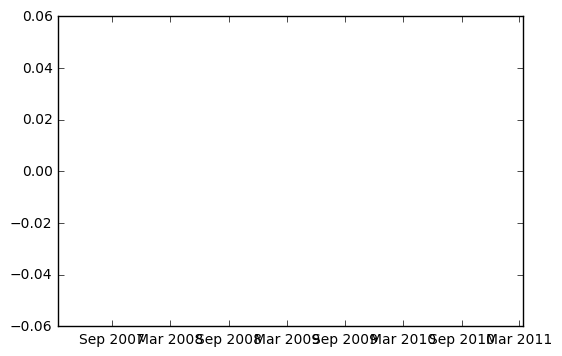

In [20]:
%matplotlib inline
for keys in nonZeroList: 
    tempPD = optionPD[keys] #stores some option PD in tempPD
    plt.plot(calDF["quote_datetime"],calDF["profit"])

In [21]:
total = 0
first = calPos[0]
first.posLong = positions[0]
print first.posLong

<__main__.Position instance at 0x0000000009DABCC8>
